# Lab Assignment Five: Wide and Deep Networks
Name: Marc Pham, Alonso Gurrola

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize_scalar, fmin_bfgs
from numpy.linalg import pinv
from sklearn.metrics import accuracy_score
from scipy.special import expit
import copy
import time
from numpy import ma # (masked array) this has most numpy functions that work with NaN data.

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.layers import Embedding, Concatenate, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model, FeatureSpace
from tensorflow.keras.metrics import FBetaScore, Precision, Recall
from tensorflow.keras import backend as K

import graphviz
import pydot

warnings.filterwarnings('ignore')

## 1. Business Understanding

The data, funded by the Instituto Politécnico de Portalegre on April 23, 2021, aims to identify students at risk of dropping out of higher education.  The dataset includes 4,424 students who are classified as dropouts, current enrollees, or graduates.  For each student, the data includes 37 total features, including demographic features (e.g., race and gender) and economic factors (e.g., the inflation rate and unemployment rate at the time of their application) that may influence their likelihood for dropping out.  The funders’ original goal was to use machine learning techniques to detect which students are at risk of dropping out and implement targeted interventions, such as scholarships, to support these students.

The end goal of analyzing this dataset is to classify a student as a potential dropout or an enrollee/graduate based on economic factors and each student’s demographic features.  The results can help university admissions offices and government agencies determine which groups of students need additional support to get through higher education.  However, it is important to note that third parties could use these results to choose which students to accept or deny from a university.  Keeping this in mind, the final classification algorithm should not be trained on race since the Supreme Court banned the use of race in college admissions.

For the algorithm to be successful, we need the algorithm to accurately classify which students are dropping out.  It is less important if the model inaccurately predicts an Enrollee as a Graduate or vice versa.  As a result, we should use metrics like precision and recall to measure how well the algorithm does at classifying dropouts.  For our algorithm, recall measures the percentage of actual dropouts that the algorithm correctly classifies.  Our recall should be as close as possible to 100% to minimize the probability of missing any students at risk of dropping out.  Precision measures the percentage of students predicted to drop out who are actual dropouts.  Low precision means we are giving additional resources to many students not at risk of dropping out, while high precision means that resources are used effectively.  Although high precision is ideal, it would be acceptable to have lower precision, like 70%, if it significantly increases recall.  The balance between precision and recall will depend on how much financial flexibility institutions have.

Sources: [Dataset](https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success)

M.V.Martins, D. Tolledo, J. Machado, L. M.T. Baptista, V.Realinho. (2021) "Early prediction of student’s performance in higher education: a case study" Trends and Applications in Information Systems and Technologies, vol.1, in Advances in Intelligent Systems and Computing series. Springer. DOI: 10.1007/978-3-030-72657-7_16

# 1. Preparation

In [40]:
df = pd.read_csv('data.csv', sep=';')
df['Target'].replace({'Enrolled' : 'Non-Dropout', 'Graduate' : 'Non-Dropout'}, inplace=True)
counts = np.unique(df['Target'],return_counts=True) # Used in another section
df = df.rename(columns = {
    'Daytime/evening attendance\t' : 'Daytime/evening attendance',               
    'Nacionality': 'Nationality'})
df['Target'].replace({'Dropout' : 1, 'Non-Dropout' : 0}, inplace=True)

df.rename(columns={
    "Marital status": "Marital_status",
    "Application mode": "Application_mode",
    "Course": "Course",
    "Daytime/evening attendance": "Daytime_evening_attendance",
    "Previous qualification": "Previous_qualification",
    "Mother's qualification": "Mother_qualification",
    "Father's qualification": "Father_qualification",
    "Mother's occupation": "Mother_occupation",
    "Father's occupation": "Father_occupation",
    "Displaced": "Displaced",
    "Educational special needs": "Educational_special_needs",
    "Debtor": "Debtor",
    "Tuition fees up to date": "Tuition_fees_up_to_date",
    "Gender": "Gender",
    "Scholarship holder": "Scholarship_holder",
    "Application order": "Application_order",
    "Previous qualification (grade)": "Previous_qualification_(grade)",
    "Admission grade": "Admission_grade",
    "Age at enrollment": "Age_at_enrollment",
    "Curricular units 1st sem (credited)": "Curricular_units_1st_sem_(credited)",
    "Curricular units 1st sem (enrolled)": "Curricular_units_1st_sem_(enrolled)",
    "Curricular units 1st sem (evaluations)": "Curricular_units_1st_sem_(evaluations)",
    "Curricular units 1st sem (approved)": "Curricular_units_1st_sem_(approved)",
    "Curricular units 1st sem (grade)": "Curricular_units_1st_sem_(grade)",
    "Curricular units 1st sem (without evaluations)": "Curricular_units_1st_sem_(without_evaluations)",
    "Curricular units 2nd sem (credited)": "Curricular_units_2nd_sem_(credited)",
    "Curricular units 2nd sem (enrolled)": "Curricular_units_2nd_sem_(enrolled)",
    "Curricular units 2nd sem (evaluations)": "Curricular_units_2nd_sem_(evaluations)",
    "Curricular units 2nd sem (approved)": "Curricular_units_2nd_sem_(approved)",
    "Curricular units 2nd sem (grade)": "Curricular_units_2nd_sem_(grade)",
    "Curricular units 2nd sem (without evaluations)": "Curricular_units_2nd_sem_(without_evaluations)",
    "Unemployment rate": "Unemployment_rate",
    "Inflation rate": "Inflation_rate",
    "GDP": "GDP"
}, inplace=True)

## 1.1: Removing Variables
When training a classification algorithm to predict whether or not a student will drop out, it is crucial to exclude factors like Race and Nationality to prevent the model from developing biases towards specific racial groups. However, simply removing Nationality as a feature may not be enough, as other variables strongly correlated with race could still introduce bias into the algorithm. As a result, we need to identify which other variables could potentially introduce racial bias into the algorithm.

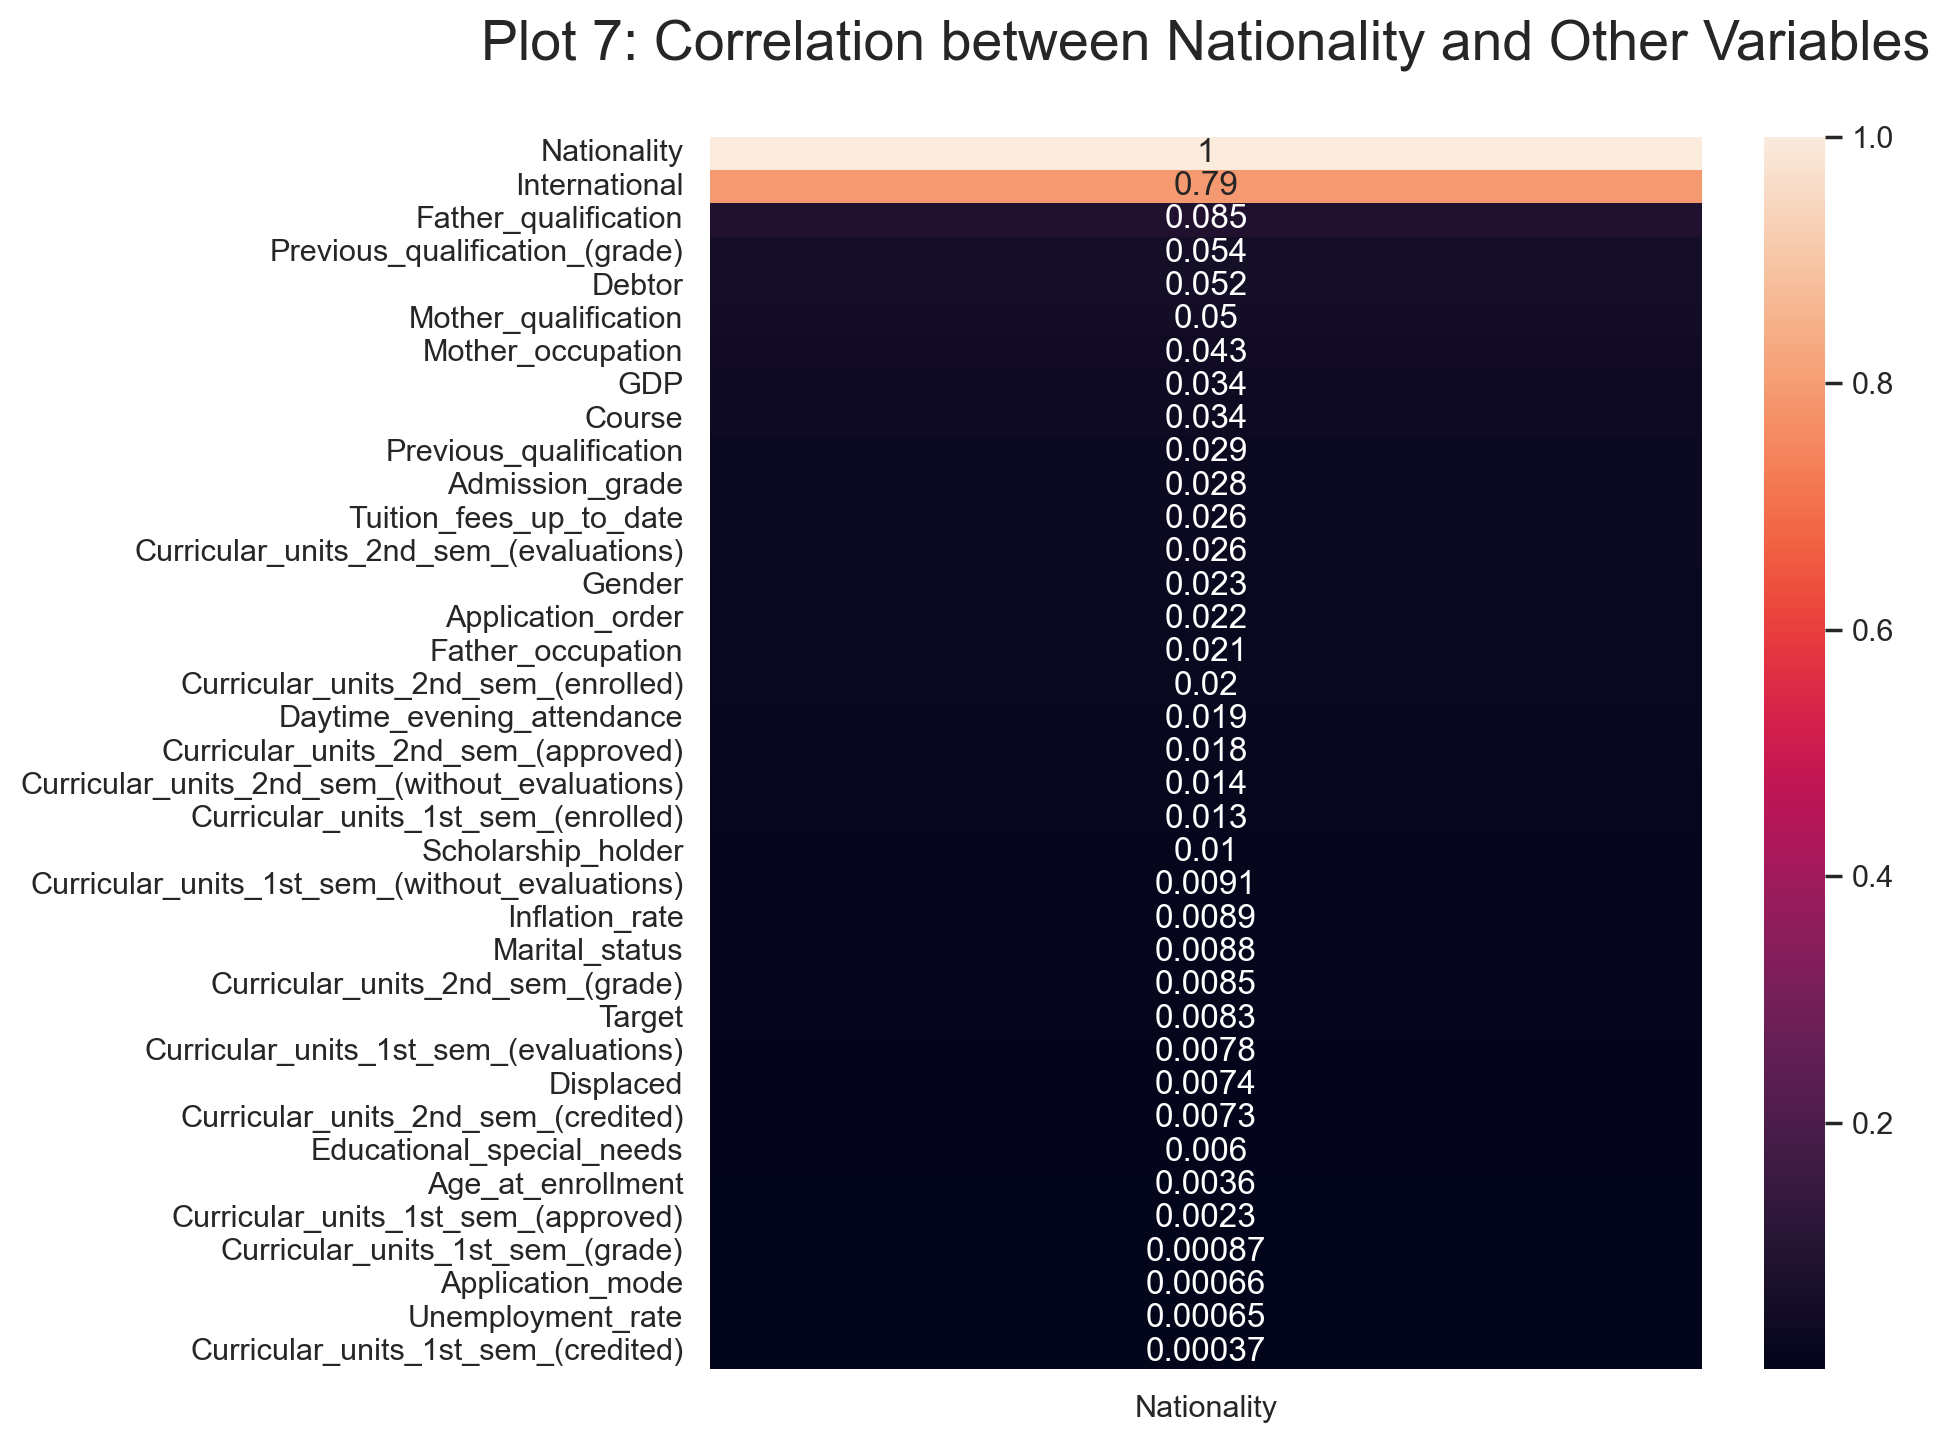

In [41]:
cmap = sns.set(style="darkgrid")
f, ax = plt.subplots(figsize=(8, 8), dpi=200)
sns.heatmap(df.corr()[['Nationality']].abs().sort_values(by='Nationality',ascending=False), cmap=cmap, annot=True);
ax.set_title("Plot 7: Correlation between Nationality and Other Variables\n", fontsize=20);

# From the results, we remove Nationality and International
df = df.drop(['Nationality', 'International'], axis=1)

The correlation table shows that Nationality has a positive correlation with the International feature. However, Nationality has a weak correlation with the other features in the dataset, including the Target label we are trying to predict. As a result, removing Nationality and International as features from the classification algorithm will likely not have a substantial impact on the prediction accuracy.

## 1.2: Train-Test Split
To divide our data, we will use a shuffled train-test split of 75-25 because we want to evaluate how well our model would perform on multiple training and test data combinations. Although our dataset is somewhat unbalanced, we decided not to use a stratified split because the category we care about predicting accurately (Dropouts) makes up a significant portion of the data (32%). If this percentage was lower around 10%, we may consider pursuing a stratified split. Using cross-validation was not necessary since we have a fairly large dataset of 4424 examples. We decided against splitting the test set into a test + validation set because we are not finetuning many parameters in our model training process and this would take away from the amount of data we could use to train and test our model.

In [42]:
stats = pd.DataFrame(counts, columns=counts[0]).iloc[1:]
stats.loc[-1] = counts[1] * 100 / np.sum(counts[1])
stats.reset_index(drop=True)

,Dropout,Non-Dropout
0,1421,3003
1,32.120253,67.879747


In practice, third parties like university admissions offices and government agencies would predict whether or not incoming university students are likely to dropout or graduate. Universities have a variety of different sizes for their incoming class, ranging from 1,000 students to 8,000 students. To mirror how the algorithm will be used, we decided on a 75% training set (3318 examples) and 25% test set (1106 examples), so we could test how accurate the algorithm would be when predicting on a thousand students.

Sources: [Sizes of Freshman Classes](https://www.forbes.com/sites/michaeltnietzel/2022/08/21/these-colleges-and-universities-are-reporting-record-size-freshmen-classes/)

In [43]:
df_train, df_test = train_test_split(df, test_size=0.25, random_state=69)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True);

## 1.3: Cross Features and Scaling

In [44]:
categorical_headers = ["Marital_status", "Application_mode", "Course", "Daytime_evening_attendance", "Previous_qualification", "Mother_qualification", "Father_qualification", "Mother_occupation", "Father_occupation", "Displaced", "Educational_special_needs", "Debtor", "Tuition_fees_up_to_date", "Gender", "Scholarship_holder"]
numeric_headers = ["Application_order", "Previous_qualification_(grade)", "Admission_grade", "Age_at_enrollment", "Curricular_units_1st_sem_(credited)", "Curricular_units_1st_sem_(enrolled)", "Curricular_units_1st_sem_(evaluations)", "Curricular_units_1st_sem_(approved)", "Curricular_units_1st_sem_(grade)", "Curricular_units_1st_sem_(without_evaluations)", "Curricular_units_2nd_sem_(credited)", "Curricular_units_2nd_sem_(enrolled)", "Curricular_units_2nd_sem_(evaluations)", "Curricular_units_2nd_sem_(approved)", "Curricular_units_2nd_sem_(grade)", "Curricular_units_2nd_sem_(without_evaluations)", "Unemployment_rate", "Inflation_rate", "GDP"]

def create_dataset_from_dataframe(df_input):

    df = df_input.copy()
    labels = df['Target']

    df = {key: value.values[:,np.newaxis] for key, value in df_input[categorical_headers+numeric_headers].items()}

    # create the Dataset here
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    
    # now enable batching and prefetching
    batch_size = 64
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    
    return ds

ds_train = create_dataset_from_dataframe(df_train)
ds_test = create_dataset_from_dataframe(df_test)

Our feature space will one-hot encode all categorical variables, which have already been converted to integers, and scales all the numeric variables. We decided to cross the features Tuition fees up to date x Scholarship holder x Debtor to capture several potential factors related to financial hardship when going to university, such as not having a scholarship or previously being in debt. However, we avoided crossing variables like Mother's/Father's qualification and occupation due to the high cardinality of these features. Crossing them would significantly increase the dimensionality of the data without contributing much more predictive value. Additionally, although there may be interesting patterns in the interaction between Marital Status and Gender (e.g., differences between married vs. single women or married vs. single men), we chose not to include this cross feature. Recent studies have shown that some employers hold biased views about married women, assuming they will be less committed to their jobs due to parental responsibilities. Men get the opposite treatment, with employers offering higher salaries and more interviews to married men compared to single ones. To avoid reinforcing such discriminatory patterns, we prefer not to let the model implicitly learn these biases.

Sources: [Married Women](https://www.gelawyer.com/blog/2021/04/married-or-unmarried-women-face-discrimination-in-their-careers/#:~:text=What%20stereotypes%20work%20against%20married,to%20decide%20to%20have%20children.), [Married Men](https://www.psychologytoday.com/us/blog/living-single/202110/married-men-paid-more-than-single-men-get-more-interviews)

In [45]:
feature_space = FeatureSpace(
    features={
        # Categorical feature encoded as string
        "Marital_status": FeatureSpace.integer_categorical(num_oov_indices=1),
        "Application_mode": FeatureSpace.integer_categorical(num_oov_indices=1),
        "Course": FeatureSpace.integer_categorical(num_oov_indices=1),
        "Daytime_evening_attendance": FeatureSpace.integer_categorical(num_oov_indices=1),
        "Previous_qualification": FeatureSpace.integer_categorical(num_oov_indices=1),
        "Mother_qualification": FeatureSpace.integer_categorical(num_oov_indices=1),
        "Father_qualification": FeatureSpace.integer_categorical(num_oov_indices=1),
        "Mother_occupation": FeatureSpace.integer_categorical(num_oov_indices=1),
        "Father_occupation": FeatureSpace.integer_categorical(num_oov_indices=1),
        "Displaced": FeatureSpace.integer_categorical(num_oov_indices=1),
        "Educational_special_needs": FeatureSpace.integer_categorical(num_oov_indices=1),
        "Debtor": FeatureSpace.integer_categorical(num_oov_indices=1),
        "Tuition_fees_up_to_date": FeatureSpace.integer_categorical(num_oov_indices=1),
        "Gender": FeatureSpace.integer_categorical(num_oov_indices=1),
        "Scholarship_holder": FeatureSpace.integer_categorical(num_oov_indices=1),

        # All numeric variables
        "Application_order": FeatureSpace.float_normalized(),
        "Previous_qualification_(grade)": FeatureSpace.float_normalized(),
        "Admission_grade": FeatureSpace.float_normalized(),
        "Age_at_enrollment": FeatureSpace.float_normalized(),
        "Curricular_units_1st_sem_(credited)": FeatureSpace.float_normalized(),
        "Curricular_units_1st_sem_(enrolled)": FeatureSpace.float_normalized(),
        "Curricular_units_1st_sem_(evaluations)": FeatureSpace.float_normalized(),
        "Curricular_units_1st_sem_(approved)": FeatureSpace.float_normalized(),
        "Curricular_units_1st_sem_(grade)": FeatureSpace.float_normalized(),
        "Curricular_units_1st_sem_(without_evaluations)": FeatureSpace.float_normalized(),
        "Curricular_units_2nd_sem_(credited)": FeatureSpace.float_normalized(),
        "Curricular_units_2nd_sem_(enrolled)": FeatureSpace.float_normalized(),
        "Curricular_units_2nd_sem_(evaluations)": FeatureSpace.float_normalized(),
        "Curricular_units_2nd_sem_(approved)": FeatureSpace.float_normalized(),
        "Curricular_units_2nd_sem_(grade)": FeatureSpace.float_normalized(),
        "Curricular_units_2nd_sem_(without_evaluations)": FeatureSpace.float_normalized(),
        "Unemployment_rate": FeatureSpace.float_normalized(),
        "Inflation_rate": FeatureSpace.float_normalized(),
        "GDP": FeatureSpace.float_normalized()
    },
    crosses=[
        FeatureSpace.cross(feature_names=('Tuition_fees_up_to_date', 'Scholarship_holder', 'Debtor'), crossing_dim=2*2*2),
    ],
    output_mode="concat"
)



In [46]:
train_ds_with_no_labels = ds_train.map(lambda x, _: x)
feature_space.adapt(train_ds_with_no_labels)

# now define a preprocessing operation that returns the processed features
preprocessed_ds_train = ds_train.map(lambda x, y: (feature_space(x), y), 
                                     num_parallel_calls=tf.data.AUTOTUNE)
# run it so that we can use the pre-processed data
preprocessed_ds_train = preprocessed_ds_train.prefetch(tf.data.AUTOTUNE)

# do the same for the test set
preprocessed_ds_test = ds_test.map(lambda x, y: (feature_space(x), y), num_parallel_calls=tf.data.AUTOTUNE)
preprocessed_ds_test = preprocessed_ds_test.prefetch(tf.data.AUTOTUNE)

In [329]:
# # Fit on Training Data
# feature_space.adapt(X_train)

# # Apply on Both
# preprocessed_X_train = tf.data.Dataset.zip((X_train, y_train))
# preprocessed_X_train = preprocessed_X_train.map(lambda x, y: (feature_space(x), y),num_parallel_calls=tf.data.AUTOTUNE)
# preprocessed_X_train = preprocessed_X_train.prefetch(tf.data.AUTOTUNE)

# preprocessed_X_test = tf.data.Dataset.zip((X_test, y_test))
# preprocessed_X_test = preprocessed_X_test.map(lambda x, y: (feature_space(x), y),num_parallel_calls=tf.data.AUTOTUNE)
# preprocessed_X_test = preprocessed_X_test.prefetch(tf.data.AUTOTUNE)

In [378]:
preprocessed_ds_train

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 243), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.int64, name=None))>

The final dataset has 228 features with 3318 examples in the training data and 1106 examples in the test data. Scaling has been applied for numeric features, and one-hot encoding has been applied for categorical features. Dimensionality reduction (i.e. PCA) has not been applied, but we will apply an embedding layer to the categorical variables to reduce the dimensionality in the model itself.

## 1.4: Evaluation Metrics

We decided to use metrics like precision, recall, and the F-$\beta$ score to measure our algorithm's success because the algorithm only needs to succeed at identifying which students are at high risk of dropping out. It is less important if the model inaccurately predicts an Enrollee as a Graduate or vice versa. For our algorithm, recall measures the percentage of actual dropouts that the algorithm correctly classifies. Our recall should be as close as possible to 100% to minimize the probability of missing any students at risk of dropping out. Precision measures the percentage of students predicted to drop out who are actual dropouts. Low precision means we are giving additional resources to many students not at risk of dropping out, while high precision means that resources are used effectively. Although high precision is ideal, it would be acceptable to have lower precision, like 70%, if it significantly increases recall.  The balance between precision and recall will depend on how much financial flexibility institutions have. For our F-$\beta$ score, we will assign $\beta > 1$ to prioritize maximizing recall over precision for our algorithm.

# 2. Modeling

### 2.1: Source Functions

In [75]:
def setup_embedding_from_categorical(feature_space, col_name):
    # what the maximum integer value for this variable?
    # which is the same as the number of categories
    N = len(feature_space.preprocessors[col_name].get_vocabulary())
    
    # get the output from the feature space, which is input to embedding
    x = feature_space.preprocessors[col_name].output
    
    # now use an embedding to deal with integers from feature space
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col_name+'_embed')(x)
    
    x = Flatten()(x) # get rid of that pesky extra dimension (for time of embedding)
    
    return x # return the tensor here 

def setup_embedding_from_crossing(feature_space, col_name):
    # what the maximum integer value for this variable?
    
    # get the size of the feature
    N = feature_space.crossers[col_name].num_bins
    x = feature_space.crossers[col_name].output
    
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col_name+'_embed')(x)
    
    x = Flatten()(x) # get rid of that pesky extra dimension (for time of embedding)
    
    return x

def plot_metrics(history):
    plt.figure(figsize=(10,4))
    plt.subplot(3,2,1)
    plt.plot(history.history['precision'])
    
    plt.ylabel('Precision')
    plt.title('Training')
    plt.subplot(3,2,2)
    plt.plot(history.history['val_precision'])
    plt.title('Validation')
    
    plt.figure(figsize=(10,4))
    plt.subplot(3,2,3)
    plt.plot(history.history['recall'])
    
    plt.ylabel('Recall')
    plt.title('Training')
    plt.subplot(3,2,4)
    plt.plot(history.history['val_recall'])
    plt.title('Validation')
    
    plt.figure(figsize=(10,4))
    plt.subplot(3,2,5)
    plt.plot(history.history['loss'])
    plt.ylabel('Training Loss')
    plt.xlabel('epochs')
    
    plt.subplot(3,2,6)
    plt.plot(history.history['val_loss'])
    plt.xlabel('epochs');

def calculate_deep_wide_branch(feature_space, numeric_headers, categorical_headers):
    # we need to create separate lists for each branch
    crossed_outputs = []
    
    # for each crossed variable, make an embedding
    for col in feature_space.crossers.keys():
        
        x = setup_embedding_from_crossing(feature_space, col)
        
        # save these outputs in list to concatenate later
        crossed_outputs.append(x)
        
    
    # now concatenate the outputs and add a fully connected layer
    wide_branch = Concatenate(name='wide_concat')(crossed_outputs)
    
    # reset this input branch
    all_deep_branch_outputs = []
    
    # for each numeric variable, just add it in after embedding
    for idx,col in enumerate(numeric_headers):
        x = feature_space.preprocessors[col].output
        x = tf.cast(x,float) # cast an integer as a float here
        all_deep_branch_outputs.append(x)
        
    # for each categorical variable
    for col in categorical_headers:
        
        # get the output tensor from ebedding layer
        x = setup_embedding_from_categorical(feature_space, col)
        
        # save these outputs in list to concatenate later
        all_deep_branch_outputs.append(x)

    # merge the deep branches together
    deep_branch = Concatenate(name='embed_concat')(all_deep_branch_outputs)

    return wide_branch, deep_branch

def plot_metrics(history):
    plt.figure(figsize=(10,4))
    plt.subplot(3,2,1)
    plt.plot(history.history['precision'])
    
    plt.ylabel('Precision')
    plt.title('Training')
    plt.subplot(3,2,2)
    plt.plot(history.history['val_precision'])
    plt.title('Validation')
    
    plt.figure(figsize=(10,4))
    plt.subplot(3,2,3)
    plt.plot(history.history['recall'])
    
    plt.ylabel('Recall')
    plt.title('Training')
    plt.subplot(3,2,4)
    plt.plot(history.history['val_recall'])
    plt.title('Validation')
    
    plt.figure(figsize=(10,4))
    plt.subplot(3,2,5)
    plt.plot(history.history['loss'])
    plt.ylabel('Training Loss')
    plt.xlabel('epochs')
    
    plt.subplot(3,2,6)
    plt.plot(history.history['val_loss'])
    plt.xlabel('epochs');

### 2.2: The Actual Network

In [76]:
Metrics = [
    Precision(name='precision'),
    Recall(name='recall'),
    "accuracy"
]

In [77]:
dict_inputs = feature_space.get_inputs() # need to use unprocessed features here, to gain access to each output
wide_branch, deep_branch = calculate_deep_wide_branch(feature_space, numeric_headers, categorical_headers)

deep_branch = Dense(units=50,activation='relu', name='deep1')(deep_branch)
deep_branch = Dense(units=25,activation='relu', name='deep2')(deep_branch)
deep_branch = Dense(units=10,activation='relu', name='deep3')(deep_branch)
    
# merge the deep and wide branch
final_branch = Concatenate(name='concat_deep_wide')([deep_branch, wide_branch])
final_branch = Dense(units=1,activation='sigmoid', name='d')(final_branch)

training_model = keras.Model(inputs=dict_inputs, outputs=final_branch)
training_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=Metrics)

In [78]:
history = training_model.fit(
    ds_train, epochs=25, validation_data=ds_test, verbose=2
)

Epoch 1/25
52/52 - 1s - loss: 0.5901 - precision: 0.5316 - recall: 0.4140 - accuracy: 0.6968 - val_loss: 0.4757 - val_precision: 0.8111 - val_recall: 0.4848 - val_accuracy: 0.7939 - 972ms/epoch - 19ms/step
Epoch 2/25
52/52 - 0s - loss: 0.4097 - precision: 0.8257 - recall: 0.6002 - accuracy: 0.8321 - val_loss: 0.3920 - val_precision: 0.7986 - val_recall: 0.6116 - val_accuracy: 0.8219 - 74ms/epoch - 1ms/step
Epoch 3/25
52/52 - 0s - loss: 0.3573 - precision: 0.8358 - recall: 0.6881 - accuracy: 0.8574 - val_loss: 0.3611 - val_precision: 0.8448 - val_recall: 0.6446 - val_accuracy: 0.8445 - 78ms/epoch - 2ms/step
Epoch 4/25
52/52 - 0s - loss: 0.3314 - precision: 0.8570 - recall: 0.7079 - accuracy: 0.8692 - val_loss: 0.3433 - val_precision: 0.8592 - val_recall: 0.6722 - val_accuracy: 0.8562 - 83ms/epoch - 2ms/step
Epoch 5/25
52/52 - 0s - loss: 0.3125 - precision: 0.8706 - recall: 0.7316 - accuracy: 0.8797 - val_loss: 0.3299 - val_precision: 0.8681 - val_recall: 0.6887 - val_accuracy: 0.8635 - 

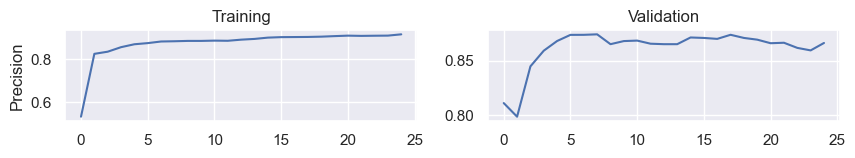

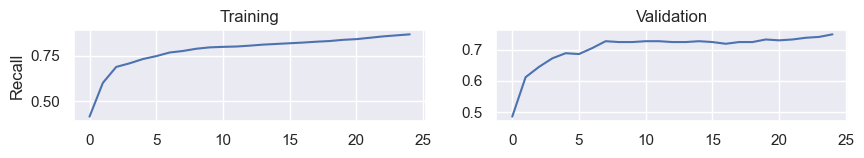

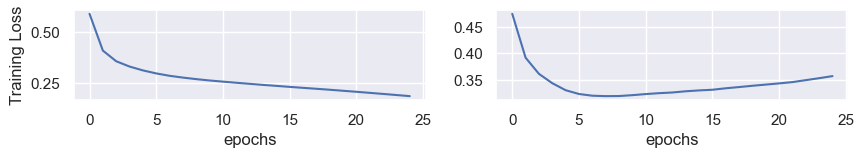

In [79]:
plot_metrics(history)

</br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br>

In [379]:
def setup_embedding_from_categorical(feature_space, col_name):
    # what the maximum integer value for this variable?
    # which is the same as the number of categories
    N = len(feature_space.preprocessors[col_name].get_vocabulary())
    
    # get the output from the feature space, which is input to embedding
    x = feature_space.preprocessors[col_name].output
    
    # now use an embedding to deal with integers from feature space
    x = Embedding(input_dim=N, # Number of categories.
                  output_dim=int(np.sqrt(N)), # Can be chosen to be log too, just chosen how much to reduce dimensions.
                  input_length=1, name=col_name+'_embed')(x)
    
    x = Flatten()(x) # get rid of that pesky extra dimension (for time of embedding)
    
    return x # return the tensor here 

def setup_embedding_from_encoding(encoded_features, col_name):
    # get the size of the feature
    x = encoded_features[col_name]
    N = x.shape[1]
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col_name+'_embed')(x)
    
    x = Flatten()(x) # get rid of that pesky extra dimension (for time of embedding)
    return x

def setup_embedding_from_crossing(feature_space, col_name):
    # get the size of the feature
    N = feature_space.crossers[col_name].num_bins
    x = feature_space.crossers[col_name].output
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col_name+'_embed')(x)
    
    x = Flatten()(x) # get rid of that pesky extra dimension (for time of embedding)
    return x

In [380]:
dict_inputs = feature_space.get_inputs() # need to use unprocessed features here, to gain access to each output

# some lists for keeping track of parts of the model
all_branch_outputs = [] # this is where we will keep track of output of each branch

# for each categorical variable
for col in categorical_headers:
    
    # get the output tensor from ebedding layer
    x = setup_embedding_from_categorical(feature_space, col)
    
    # save these outputs in list to concatenate later
    all_branch_outputs.append(x)
    
    
# for each numeric variable, just add it in after embedding
for col in numeric_headers:
    x = feature_space.preprocessors[col].output
    x = tf.cast(x,float) # cast an integer as a float here
    all_branch_outputs.append(x)
    
# now concatenate the outputs and add a fully connected layer
final_branch = Concatenate(name='concat_1')(all_branch_outputs)
final_branch = Dense(units=1,
                     activation='sigmoid', 
                     name='combined')(final_branch)

# here, since we are accessing the string lookup data directly, 
#. we cannot use the already processed data
training_model = keras.Model(inputs=dict_inputs, 
                             outputs=final_branch)

training_model.compile(
    optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]
)

training_model.summary()

plot_model(
    training_model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

Model: "model_38"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Marital_status (InputLayer  [(None, 1)]                  0         []                            
 )                                                                                                
                                                                                                  
 Application_mode (InputLay  [(None, 1)]                  0         []                            
 er)                                                                                              
                                                                                                  
 Course (InputLayer)         [(None, 1)]                  0         []                            
                                                                                           

In [370]:
dict_inputs = feature_space.get_inputs() # need to use unprocessed features here, to gain access to each output

# we need to create separate lists for each branch
# Make an embedding for each combination of crossed variable.
crossed_outputs = [setup_embedding_from_crossing(feature_space, col) for col in feature_space.crossers.keys()]


# Concatenate those embeddings into one matrix to make a fully connected layer.
wide_branch = Concatenate(name='wide_concat')(crossed_outputs)

# reset this input branch
all_deep_branch_outputs = []

# for each numeric variable, just add it in after embedding
for idx,col in enumerate(numeric_headers):
    x = feature_space.preprocessors[col].output
    x = tf.cast(x,float) # cast an integer as a float here
    all_deep_branch_outputs.append(x)
    
# for each categorical variable
for col in categorical_headers:
    
    # get the output tensor from ebedding layer
    x = setup_embedding_from_categorical(feature_space, col)
    
    # save these outputs in list to concatenate later
    all_deep_branch_outputs.append(x)


# merge the deep branches together
deep_branch = Concatenate(name='embed_concat')(all_deep_branch_outputs)
deep_branch = Dense(units=50,activation='relu', name='deep1')(deep_branch)
deep_branch = Dense(units=25,activation='relu', name='deep2')(deep_branch)
deep_branch = Dense(units=10,activation='relu', name='deep3')(deep_branch)
    
# merge the deep and wide branch
final_branch = Concatenate(name='concat_deep_wide')([deep_branch, wide_branch])
final_branch = Dense(units=1,activation='sigmoid',
                     name='combined')(final_branch)


training_model = keras.Model(inputs=dict_inputs, outputs=final_branch)
training_model.compile(
    optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]
)
training_model.summary()

Model: "model_36"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Marital_status (InputLayer  [(None, 1)]                  0         []                            
 )                                                                                                
                                                                                                  
 Application_mode (InputLay  [(None, 1)]                  0         []                            
 er)                                                                                              
                                                                                                  
 Course (InputLayer)         [(None, 1)]                  0         []                            
                                                                                           

In [322]:
training_model.output.shape

TensorShape([None, 1])

In [381]:
history = training_model.fit(
    preprocessed_ds_train, epochs=5, validation_data=preprocessed_ds_test, verbose=2
)

Epoch 1/5


ValueError: in user code:

    File "/opt/anaconda3/envs/ml_python/lib/python3.8/site-packages/keras/src/engine/training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "/opt/anaconda3/envs/ml_python/lib/python3.8/site-packages/keras/src/engine/training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/anaconda3/envs/ml_python/lib/python3.8/site-packages/keras/src/engine/training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "/opt/anaconda3/envs/ml_python/lib/python3.8/site-packages/keras/src/engine/training.py", line 1080, in train_step
        y_pred = self(x, training=True)
    File "/opt/anaconda3/envs/ml_python/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/anaconda3/envs/ml_python/lib/python3.8/site-packages/keras/src/engine/input_spec.py", line 219, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model_38" expects 34 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, None, 243) dtype=float32>]


</br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br></br>

In [268]:
feature_space.get_encoded_features()[0]

<KerasTensor: shape=(228,) dtype=float32 (created by layer 'tf.__operators__.getitem_3')>

In [411]:
# these are the placeholder inputs in the computation graph BEFORE 
# applying and transformations
dict_inputs = feature_space.get_inputs() # getting inputs is WAY easier now

# these are the encoded features after they have been processed
# We can use these as additional inpits into the computation graph
encoded_features = feature_space.get_encoded_features() # these features have been encoded
# using feature space above, this will result in 131 concatenated features
# this is calucalted based on the one-hot encodings for each category

# now lets create some layers with Keras
x = keras.layers.Dense(64, activation="relu")(encoded_features)
x = keras.layers.Dense(32, activation="relu")(x)
x = keras.layers.Dense(16, activation="relu")(x)
predictions = keras.layers.Dense(1, activation="sigmoid")(x)

# we can now create two input/outputs to the computation graph

# this expects features already transformed
training_model = keras.Model(inputs=encoded_features, 
                             outputs=predictions)
training_model.compile(
    optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]
)

# this expects features that are not transformed 
inference_model = keras.Model(inputs=dict_inputs, 
                              outputs=predictions)
inference_model.compile(loss="binary_crossentropy", metrics=["accuracy"])

inference_model.summary()

plot_model(
    training_model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

Model: "model_45"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Debtor (InputLayer)         [(None, 1)]                  0         []                            
                                                                                                  
 Scholarship_holder (InputL  [(None, 1)]                  0         []                            
 ayer)                                                                                            
                                                                                                  
 Tuition_fees_up_to_date (I  [(None, 1)]                  0         []                            
 nputLayer)                                                                                       
                                                                                           

In [74]:
# batchsize = 64
# X = X.batch(batchsize)
# X = X.prefetch(batchsize)

### 3.2.1: What impact does Nationality (race) have on predicting whether a student will drop out?
Sub-question: Which other variables are strongly correlated with Nationality and could introduce racial bias into the algorithm?

When training a classification algorithm to predict whether or not a student will drop out, it is crucial to exclude factors like Race and Nationality to prevent the model from developing biases towards specific racial groups. However, simply removing Nationality as a feature may not be enough, as other variables strongly correlated with race could still introduce bias into the algorithm. As a result, we need to identify which other variables could potentially introduce racial bias into the algorithm.


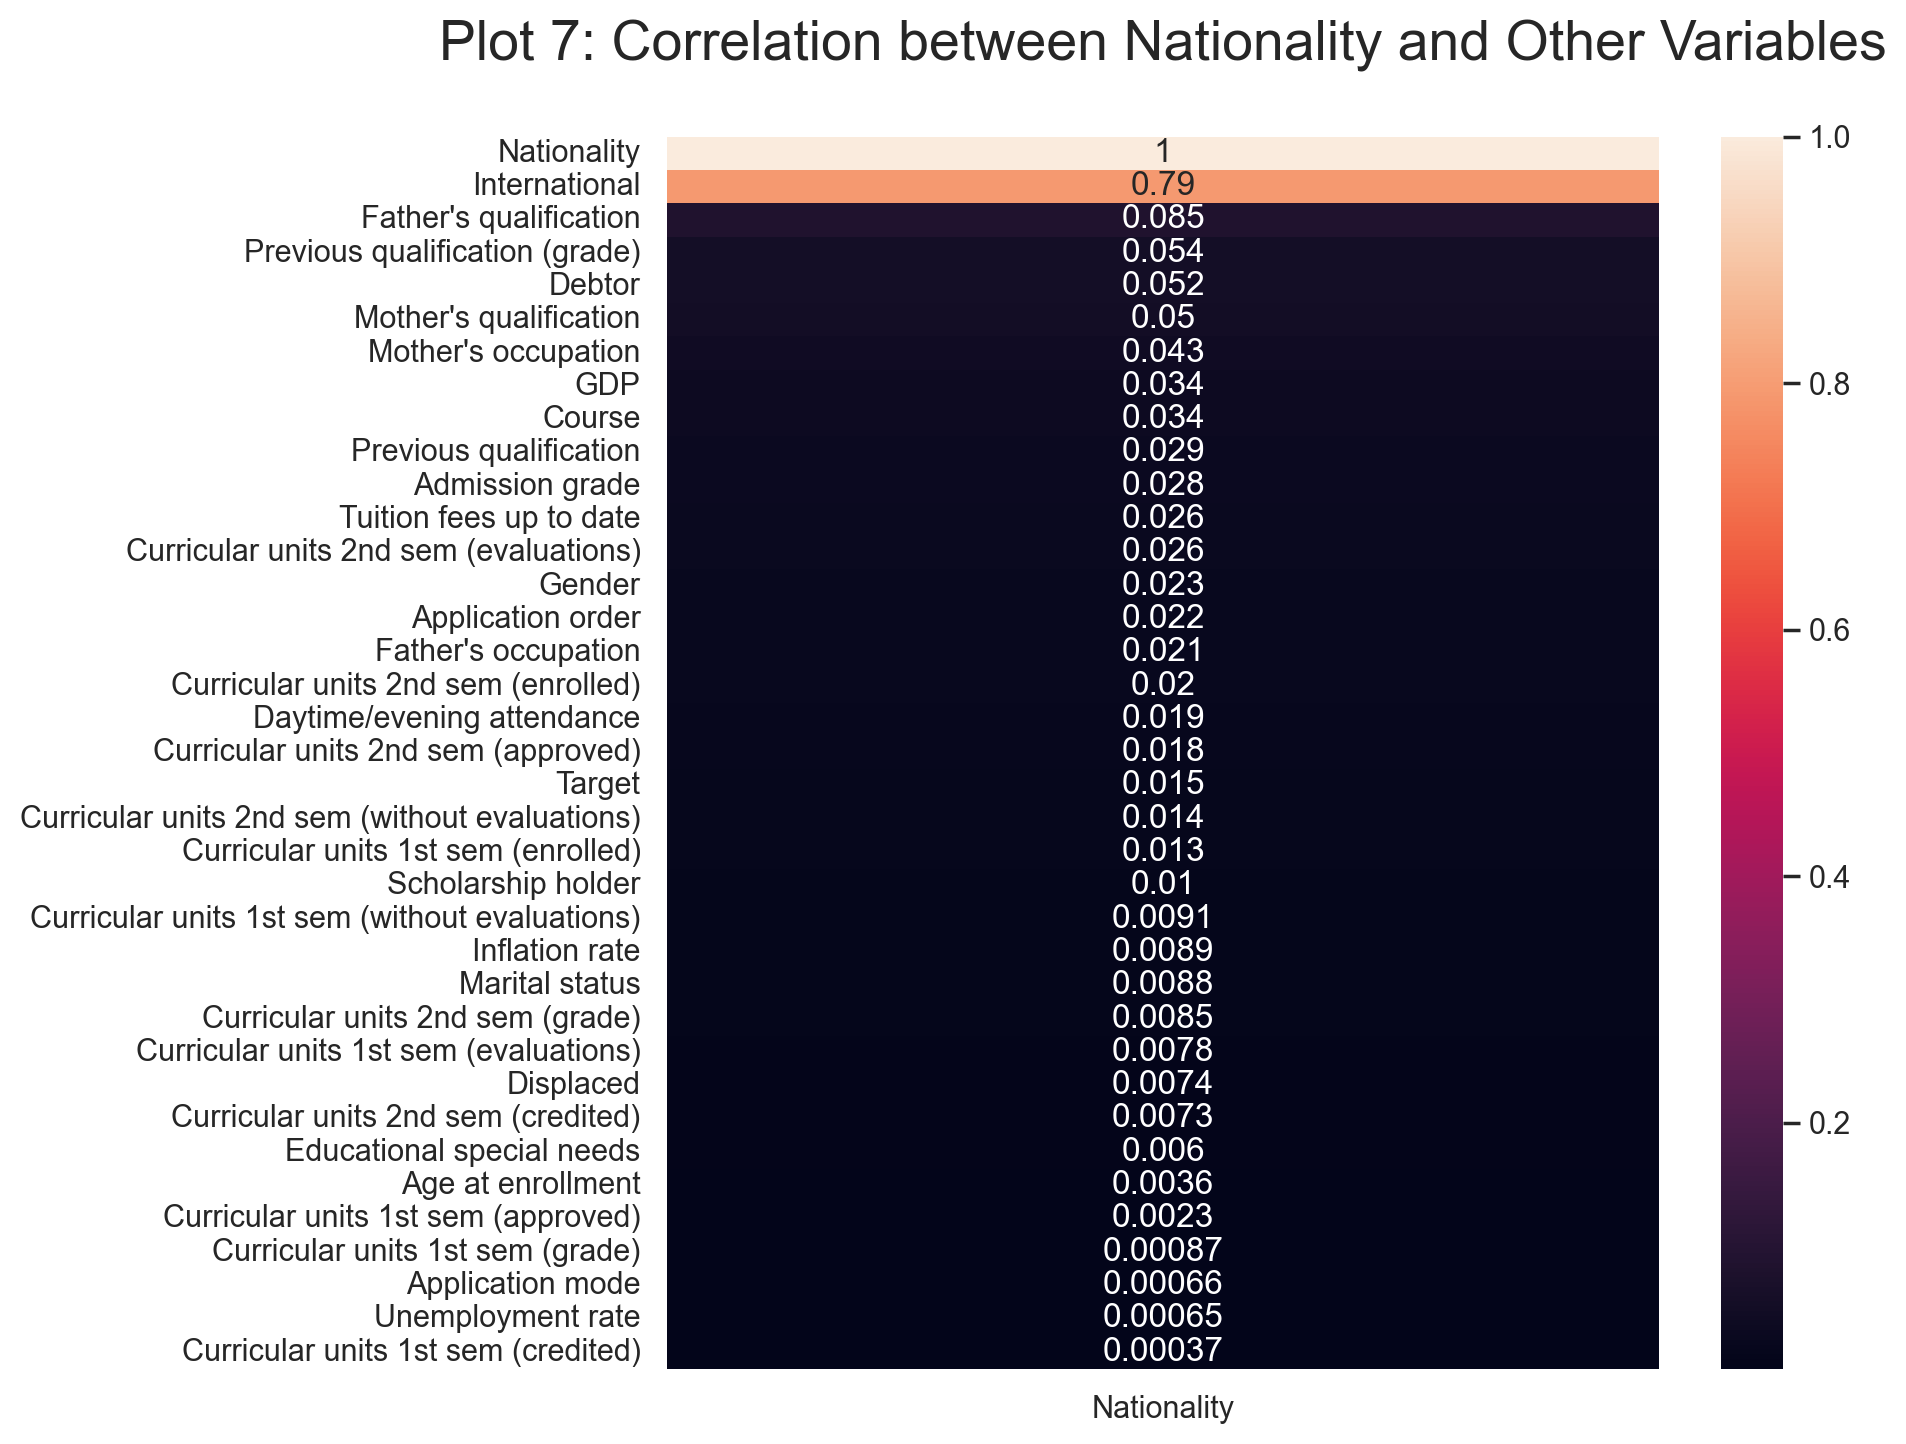

In [136]:
cmap = sns.set(style="darkgrid")
f, ax = plt.subplots(figsize=(8, 8), dpi=200)
sns.heatmap(df.corr()[['Nationality']].abs().sort_values(by='Nationality',ascending=False), cmap=cmap, annot=True);
ax.set_title("Plot 7: Correlation between Nationality and Other Variables\n", fontsize=20);


The correlation table shows that Nationality has a positive correlation with the International feature. However, Nationality has a weak correlation with the other features in the dataset, including the Target label we are trying to predict. As a result, removing Nationality and International as features from the classification algorithm will likely not have a substantial impact on the prediction accuracy.

### 3.2.2: Which features will have the most substantial impact on predicting whether a student will drop out?

We need to identify which features are correlated with the Target label variable we are trying to predict. Features with low correlation have a weak relationship with the Target variable and are less significant in the classification algorithm.  Features with too high of a correlation do not add extra information that can help to improve our algorithm. 

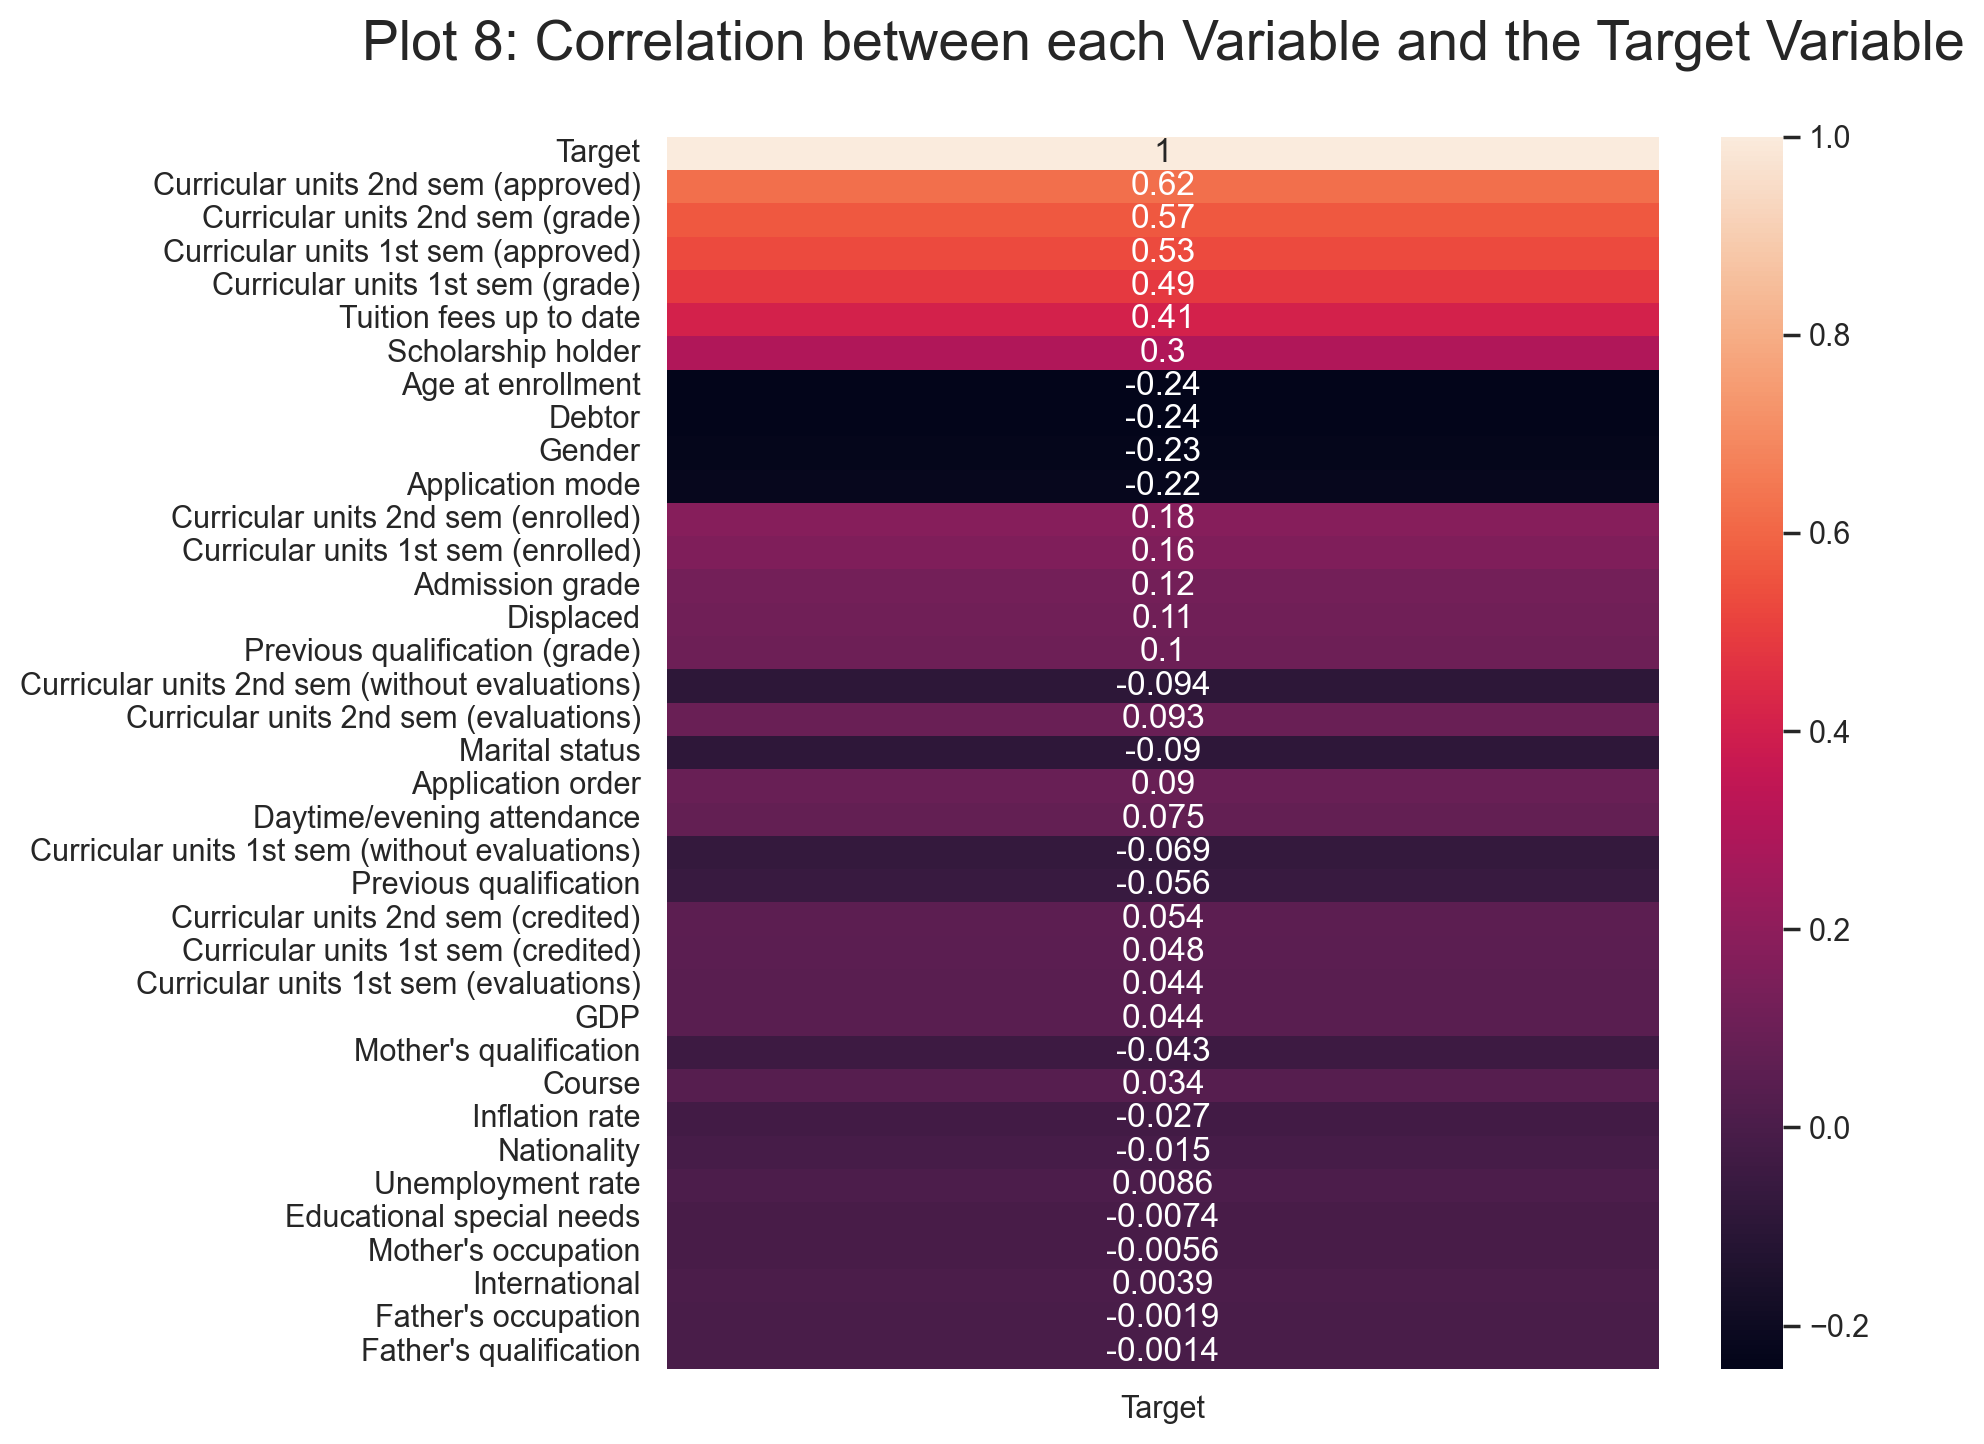

In [137]:
df_target = df.corr()[['Target']]
df_target['abs(Target)'] = df_target['Target'].abs()

cmap = sns.set(style="darkgrid")
f, ax = plt.subplots(figsize=(8, 8), dpi=200)

# Sort the Correlation Coefficients by its Magnitude but output the raw Correlation Coefficient.
sns.heatmap(pd.DataFrame(df_target.sort_values(by='abs(Target)', ascending=False)['Target']), cmap=cmap, annot=True);
ax.set_title("Plot 8: Correlation between each Variable and the Target Variable\n", fontsize=20);


The correlation table is ordered from the features with the strongest correlation (in magnitude) to those with the weakest correlation. A feature with a positive correlation is correlated with a lower chance to drop out; a feature with a negative correlation is correlated with a high chance to drop out.</br>

The features most strongly correlated with a lower chance of dropping out involved...
1. Academic Grades:</br>
   Passing (approving) more courses and having higher average grades in their first and second semesters were correlated with a lower chance of dropping out.
2. Financial Stability:</br>
   Keeping tuition fees up to date and holding scholarships were correlated with a lower chance of dropping out. Having debt was correlated with a higher chance of dropping out.
3. Some Factors like Age at enrollment and Gender that are known at the time of application.

The correlation table not strongly correlated with the Target variable included economic variables like GDP, inflation rate, and unemployment rate.


### 3.2.3: Which combinations of Gender and Age at enrollment have the highest chance of dropping out?

From the Question 3.2.2, we determined that Gender and Age at enrollment were some of the features that were negatively correlated with dropping out. As a result, it would be interesting to determine which combinations of Gender and Age are associated with the highest chance of dropping out and to identify some potential reasons why this combination has the highest chance.

In [138]:
df_slim = df[['Gender', 'Age at enrollment', 'Target']].copy()
df_slim['Age Ranges'] = pd.cut(
    df_slim['Age at enrollment'],
    [0,18,19,20,22,25,29,39,100],
    labels=['17-18', '19', '20', '21-22', '23-25', '26-29', '30-39', '40+']
)
df_slim['Gender'].replace({0:'Female', 1:'Male'}, inplace=True)
df_slim['Target'].replace({2:0, 3:0}, inplace=True)
df_slim['Target'].replace({0:1, 1:0}, inplace=True)
# Dropouts = 0, Non-Dropouts = 1


We split Age at enrollment into several Age Ranges:
- 17-18: Entered higher education right after finishing secondary education (high school).
- 19: Entered higher education 1 year after finishing secondary education.
- 20: Entered higher education 2 years after finishing secondary education.
- 21-22
- 23-25
- 26-29
- Thirties
- Forties and Above

Gender was split into Male and Female.

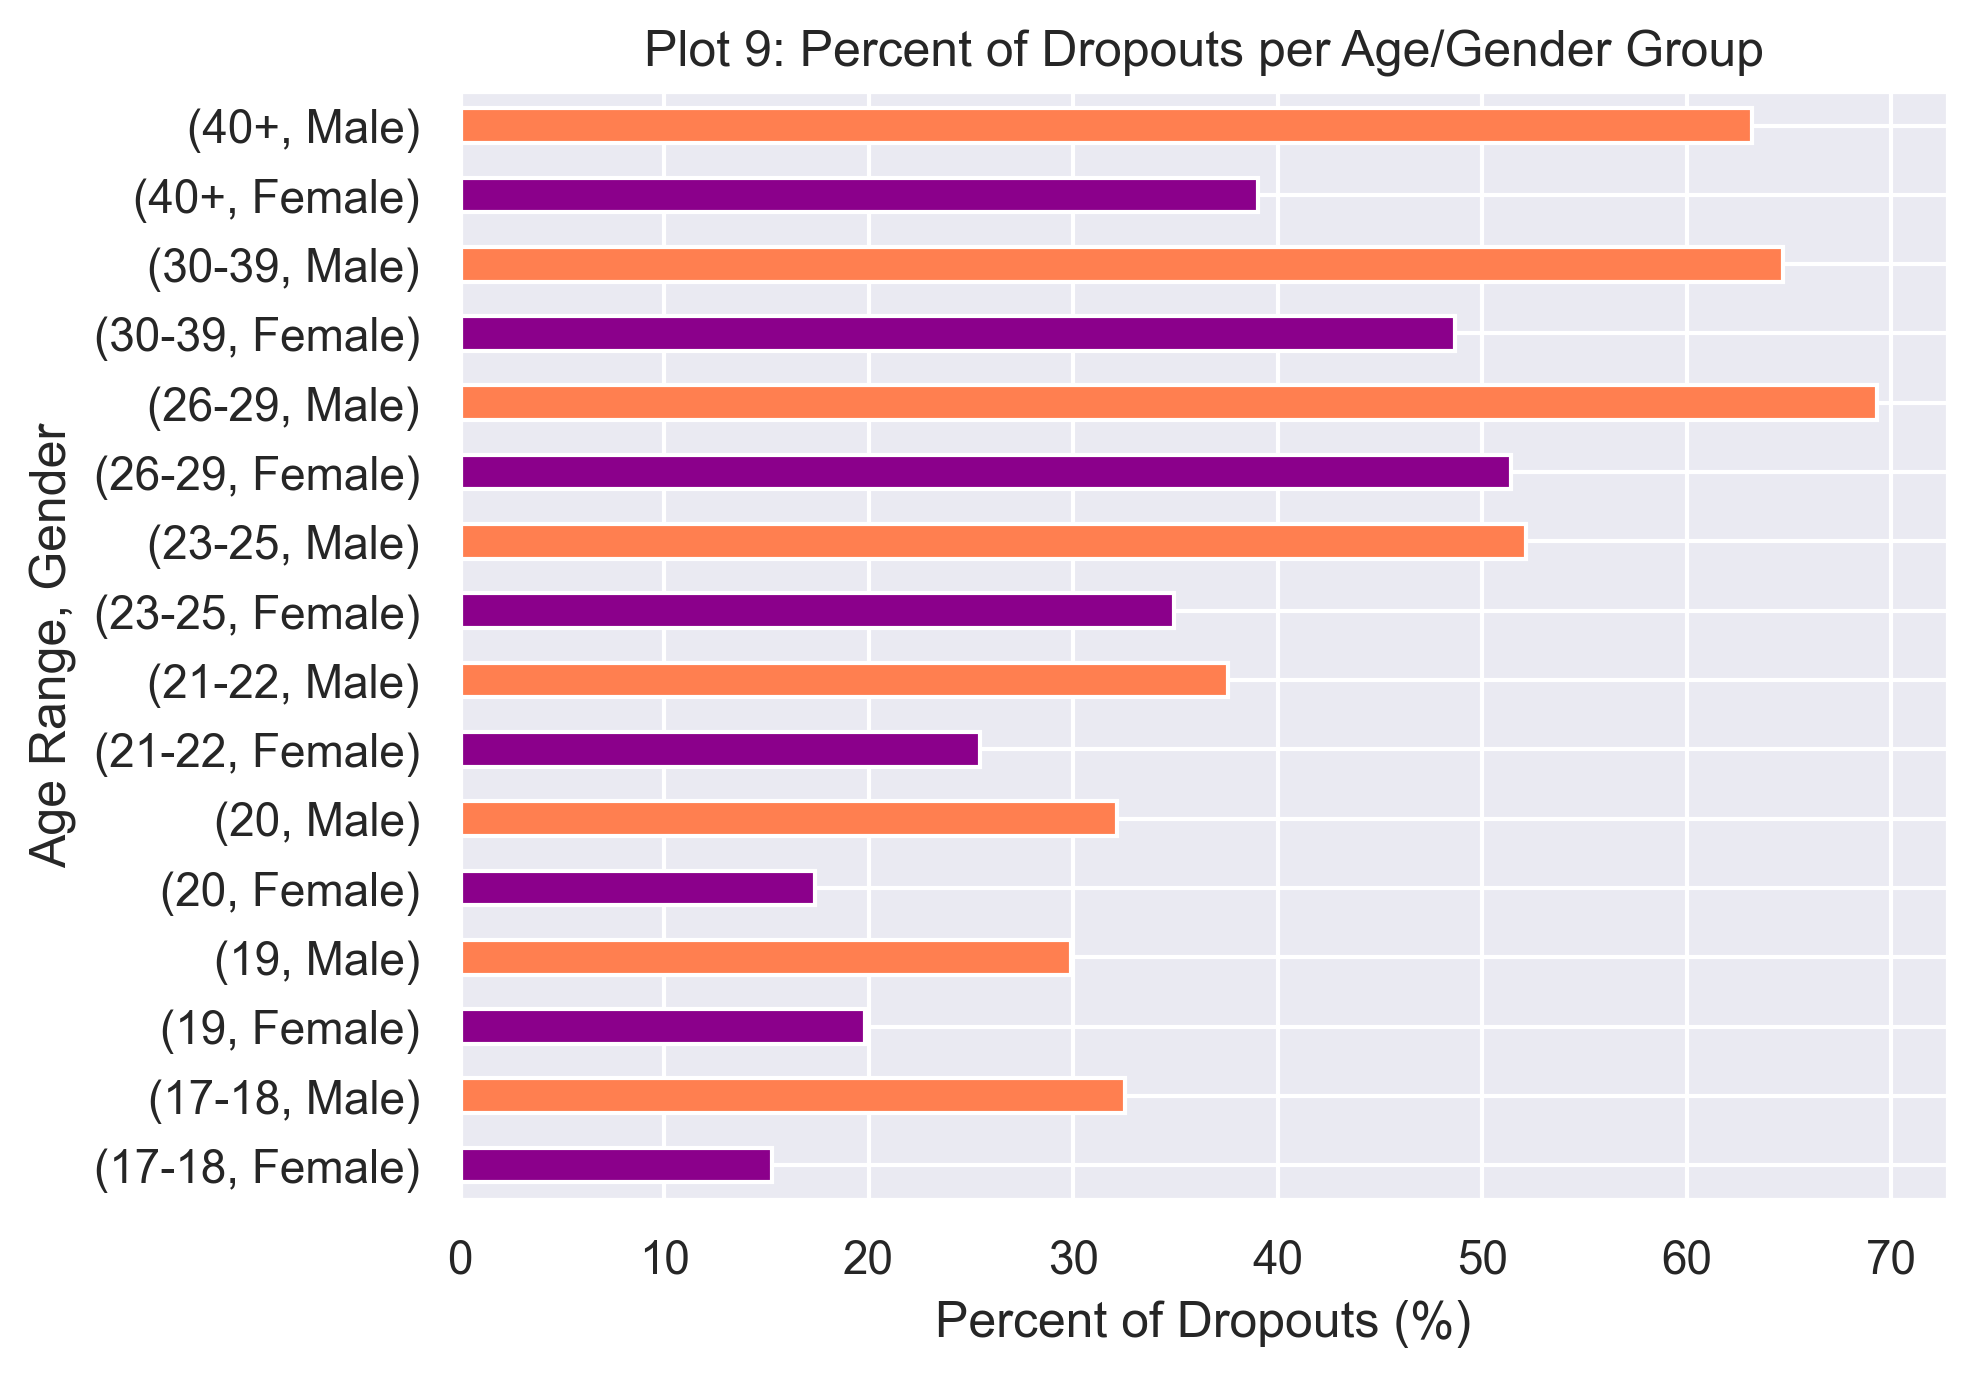

In [139]:
fig, ax = plt.subplots(dpi=300)
df_grouped = df_slim.groupby(by=['Age Ranges','Gender'])
dropout_percent = 100 * (1 - (df_grouped['Target'].sum() / df_grouped['Target'].count()))
colors=['darkmagenta', 'coral']

ax = dropout_percent.plot(kind='barh', color=colors)
ax.set_ylabel('Age Range, Gender');
ax.set_xlabel('Percent of Dropouts (%)');
ax.set_title('Plot 9: Percent of Dropouts per Age/Gender Group');

The plot reveals that men aged 26-29 had the highest percentage of dropouts, closely followed by men in their thirties and forties. Across all age ranges, men had a higher percentage of dropouts than women, reinforcing the correlation between gender and the chances of dropping out discussed in Section 3.2.2. For both genders, the percent of dropouts generally increased with age, peaking at the 26-29 age range. After this peak, the percent of dropouts declined as age continued to increase.

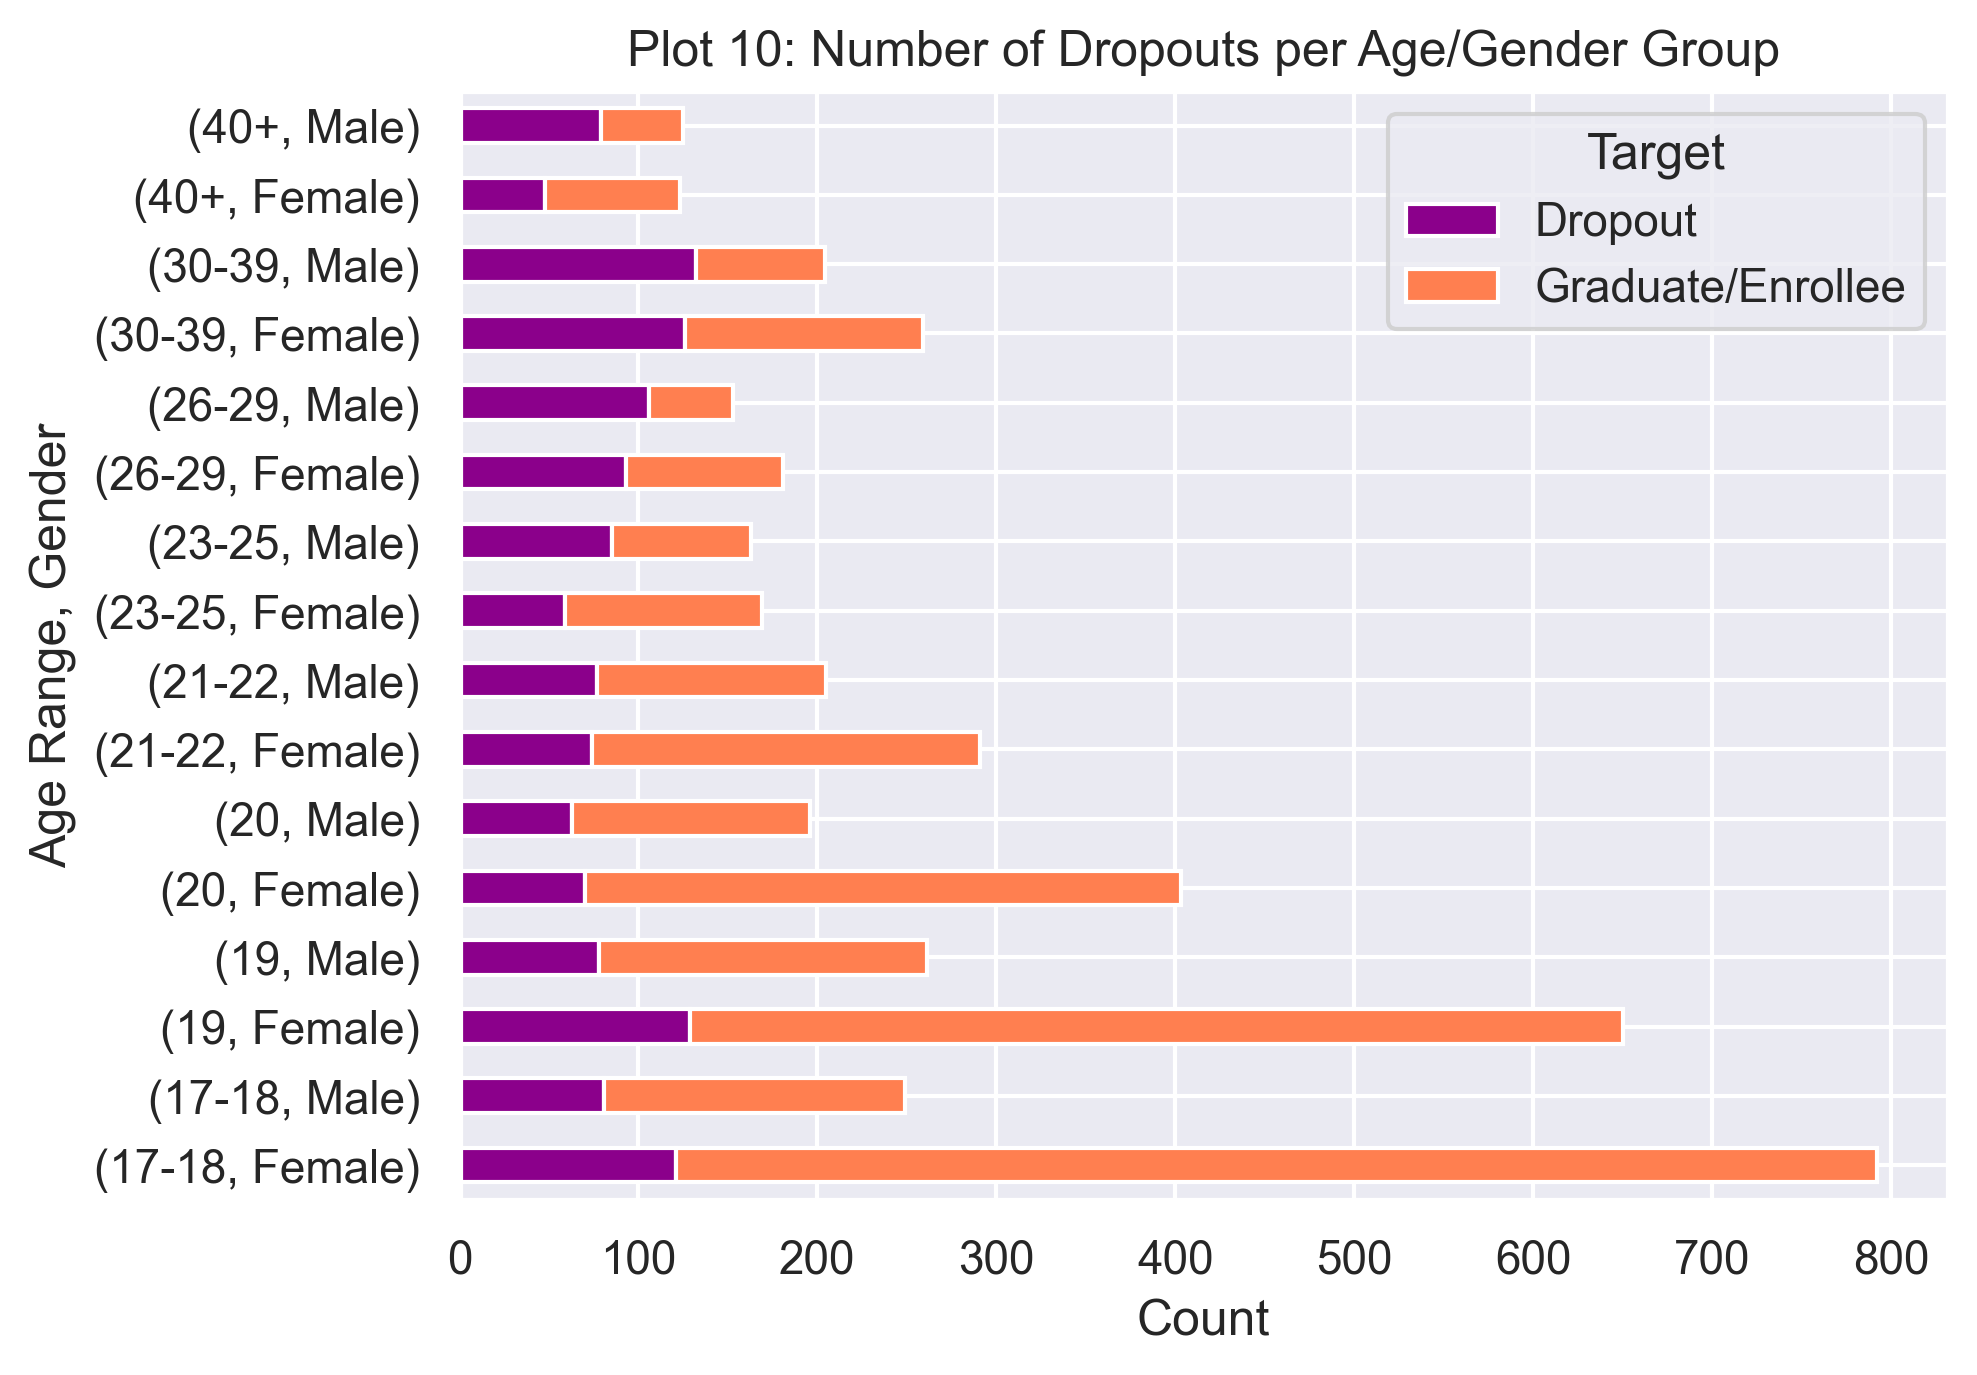

In [140]:
fig, ax = plt.subplots(dpi=300)

survival = pd.crosstab(
    [df_slim['Age Ranges'], df_slim['Gender']],
    df_slim['Target'].astype(bool)
    )
survival.plot(kind='barh', stacked=True, ax=ax, color=['darkmagenta', 'coral'])
ax.legend(['Dropout', 'Graduate/Enrollee'], title='Target')
ax.set_ylabel('Age Range, Gender')
ax.set_xlabel('Count')
ax.set_title('Plot 10: Number of Dropouts per Age/Gender Group')
plt.show()

The plot reveals a potential reason why there may be a disparity in the percent of dropouts for men and women at younger age ranges. The number of male students is less than the number of female students for younger age ranges. As a result, even though men have less dropouts than women in younger age ranges, the percent of dropouts is higher for men.

### 3.2.4: Extra Question: Are Scholarship Holders More Likely to Drop Out due to a Lack of Scholarships?

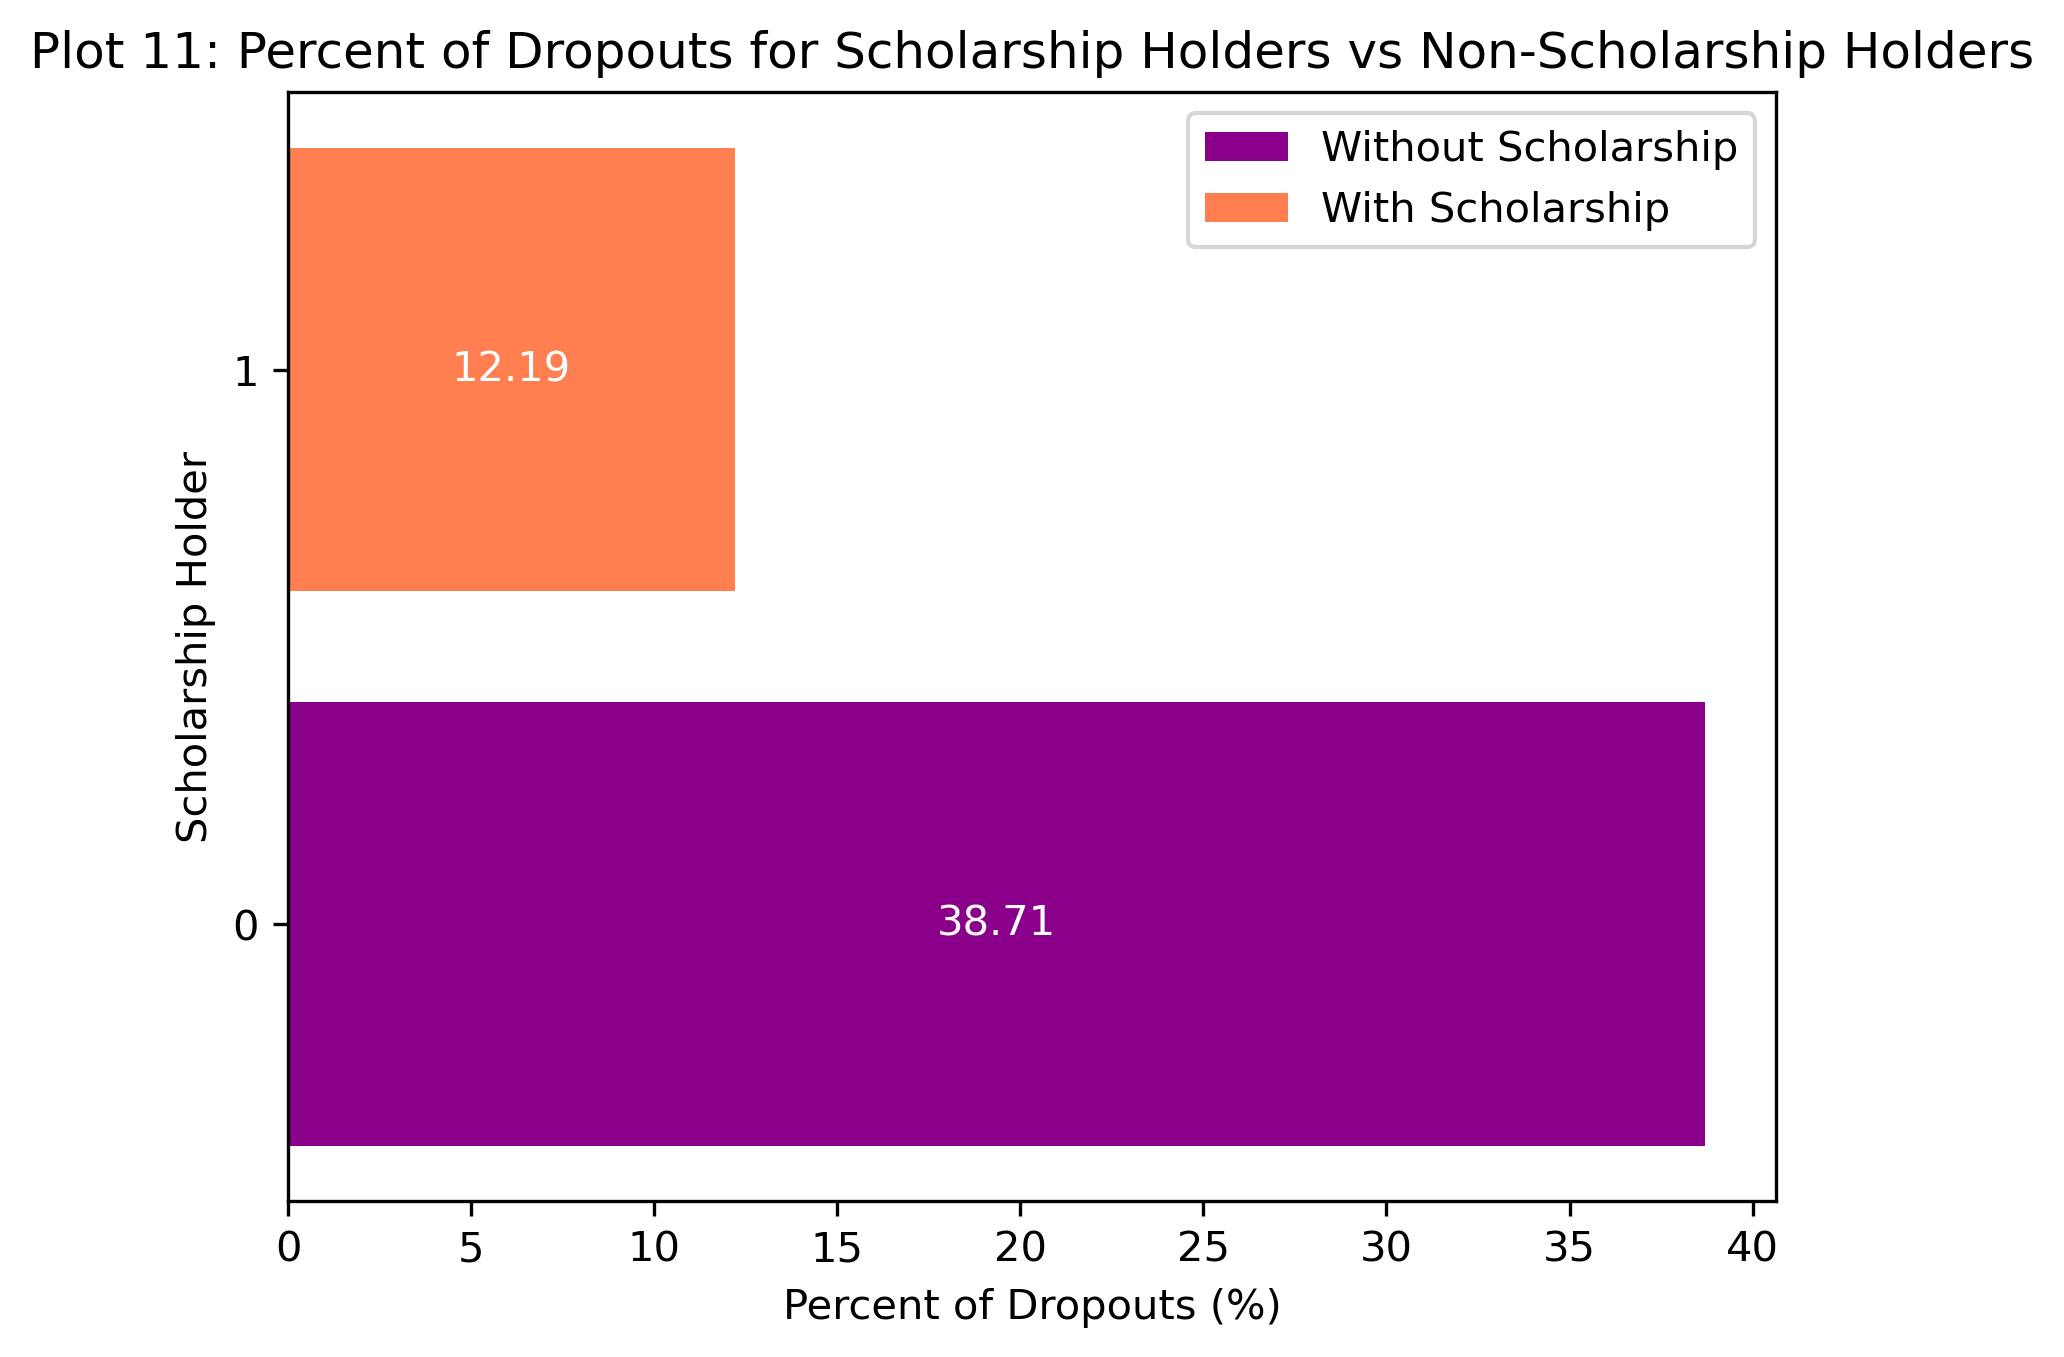

In [9]:
df_scholarship = df[['Scholarship holder', 'Target']].copy()

# Replace Target values for the purpose of this analysis
df_scholarship['Target'].replace({2:0, 3:0}, inplace=True)  # Non-dropouts as 0
df_scholarship['Target'].replace({0:1, 1:0}, inplace=True)  # Dropouts as 1

# Plot dropout percentage by scholarship status
fig, ax = plt.subplots(dpi=300)
df_grouped_scholar = df_scholarship.groupby(by=['Scholarship holder'])
dropout_percent_scholar = 100 * (1 - (df_grouped_scholar['Target'].sum() / df_grouped_scholar['Target'].count()))
colors = ['darkmagenta', 'coral']

bars = ax.barh(dropout_percent_scholar.index, dropout_percent_scholar, color=colors)

ax = dropout_percent_scholar.plot(kind='barh', color=colors)
scholar_legend = ['Without Scholarship', 'With Scholarship']
ax.legend(bars, scholar_legend, loc='upper right')
ax.set_ylabel('Scholarship Holder')
ax.set_xlabel('Percent of Dropouts (%)')
ax.set_title('Plot 11: Percent of Dropouts for Scholarship Holders vs Non-Scholarship Holders')
ax.bar_label(ax.containers[0], fontsize=10, fmt='%0.2f', label_type='center', color='white')

plt.show();

The plot reveals that students with scholarships have a dropout rate of roughly one-third that of students without scholarships. There are several potential reasons why this pattern exists. First, scholarships are often awarded to students who were academically successful in high school. Since these students have already built their work ethic and academic skills, they will likely succeed in university. Second, scholarships help students to afford the cost of tuition. While scholarships may not eliminate the financial burden of education, they make it easier for students to concentrate on their studies.